### Importação das Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

In [3]:
def create_sequences_mult(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)

In [4]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model

param_grid = {
                'model__neurons': [32, 64, 96],
                'model__drop': [0.1, 0.2, 0.3],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16, 32],   
                'fit__epochs': [50, 100],
                # 'model__neurons': [40],
                # 'model__drop': [0.1],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16],   
                # 'fit__epochs': [100],
              }

In [5]:
models_lstm_all = []
models_lstm_cropped = []
models_lstm_crypto_all = []
models_lstm_crypto_cropped = []
seq_len_options = [7, 14, 30]
# seq_len_options = [7]
split_options = [5, 10]
# split_options = [5]

event_date = pd.Timestamp('2024-11-05') 
event_label = "Trump Elected"

### Modelo com dado completo

In [42]:
data = pd.read_csv('../../data/processed/ETH-USD_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984


In [43]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

In [44]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_all = MinMaxScaler(feature_range=(0, 1))
  scaler_y_all = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_all.fit(X_train_reshaped)
  X_train_scaled = scaler_X_all.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_all.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_all.fit(y_train_raw)     
  y_train_scaled = scaler_y_all.transform(y_train_raw)
  y_test_scaled = scaler_y_all.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_all.append({
      "model": grid_result_all.best_estimator_,
      "params": grid_result_all.best_params_,
      "rmse": -grid_result_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_all,
      "scaler_y": scaler_y_all
    })
    
    print(f"Menor RMSE: {-grid_result_all.best_score_:.3f} usando: {grid_result_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.025 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.024 usando: {'fit__batch_size': 32, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.030 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.029 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados


In [45]:
for m in models_lstm_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_all_ordered_by_test = sorted(models_lstm_all, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_all_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.025902328574062005
n_splits: 10
seq_len: 30

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.028524248728393778
n_splits: 10
seq_len: 14

--- Modelo 3 ---
params: {'fit__batch_size': 32, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029194249067125987
n_splits: 10
seq_len: 7

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.035892992670054594
n_splits: 5
seq_len: 7

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.036775235016526533
n_splits: 5
seq_len: 30

--- Modelo 6 ---
param

In [46]:
y_pred_scaled = lstm_all_ordered_by_test[0]["model"].predict(lstm_all_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_all_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_all_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_all_ordered_by_test[0]["y_test"])

MAE normalizado: 0.018475514760696546
RMSE normalizado: 0.025902328574062005


In [47]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 87.34815343221028
RMSE real: 122.46048894447158
MAPE: 2.89%
R²: 0.97


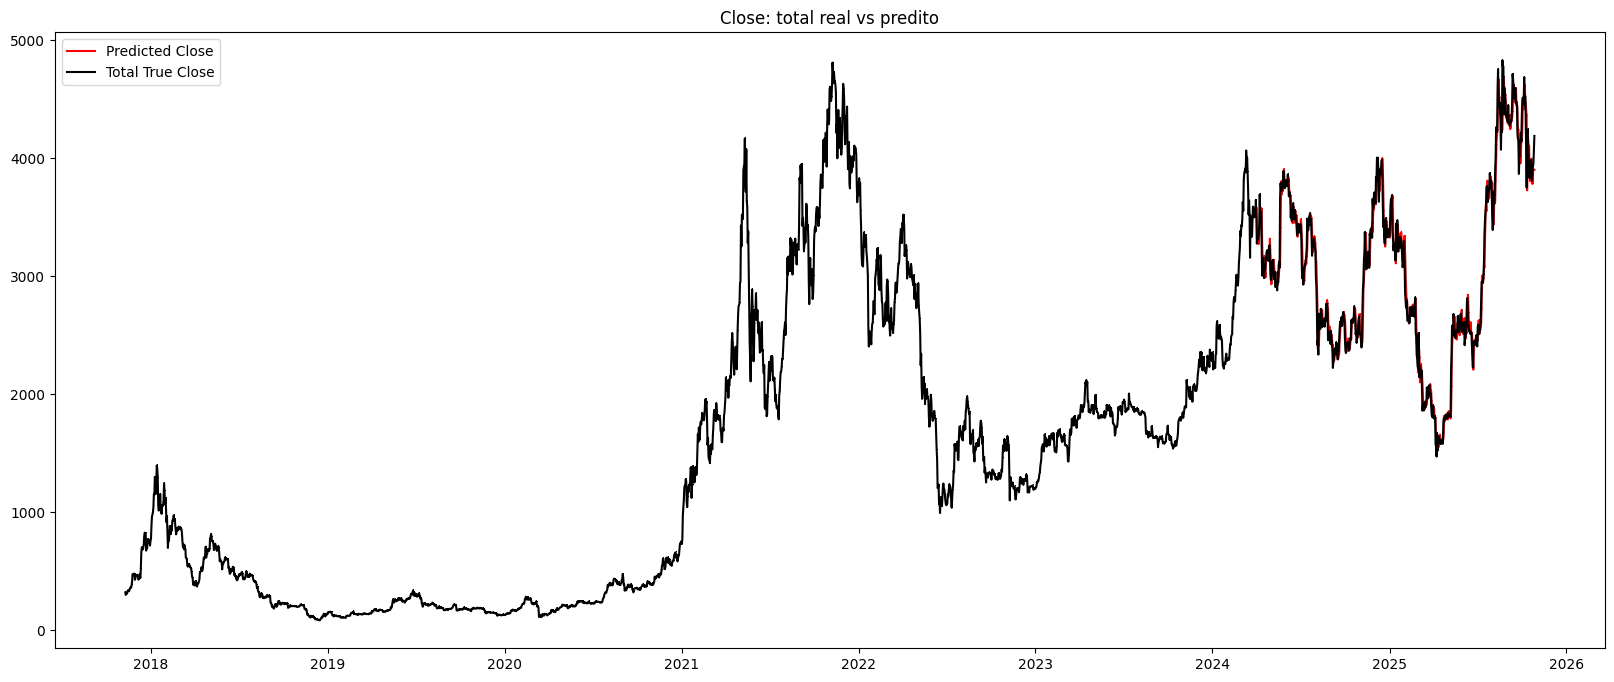

In [48]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

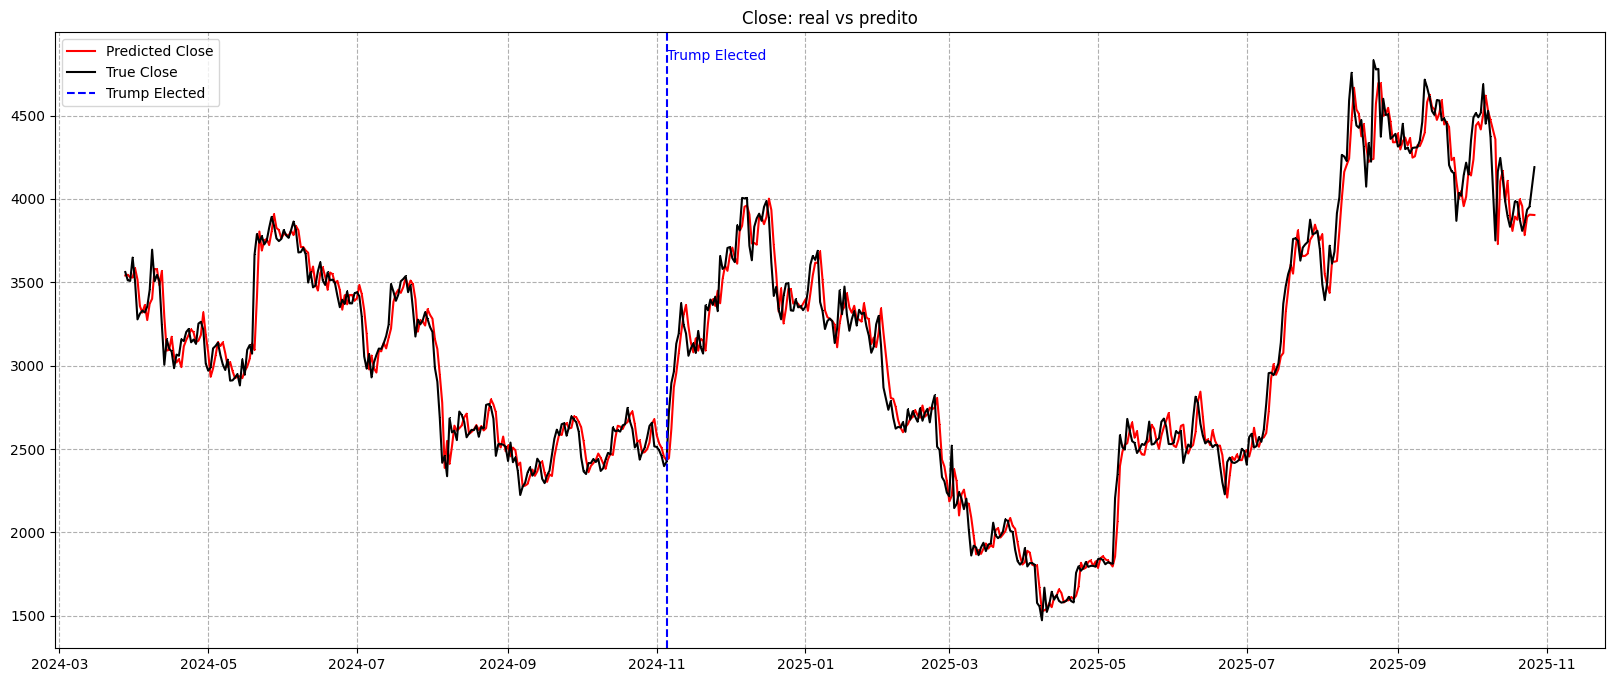

In [49]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com dado cortado (inicio ate a moeda se estabilizar foi removido)

In [5]:
data = pd.read_csv('../../data/processed/ETH-USD_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2020-06-01,246.991760,248.236282,230.488052,230.860260,13951727936
2020-06-02,237.219055,252.222000,233.225296,246.828186,13782107567
2020-06-03,244.179321,244.179321,235.464447,237.395218,9861760817
2020-06-04,244.426392,245.928970,236.765305,244.105286,10170414304
2020-06-05,241.221985,247.329498,240.682053,244.349594,9293963914


In [6]:
X_mult = data[['High', 'Low', 'Open', 'Volume']]
y_mult = data[['Close']]

In [7]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_cropped = MinMaxScaler(feature_range=(0, 1))
  scaler_y_cropped = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_cropped.fit(X_train_reshaped)
  X_train_scaled = scaler_X_cropped.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_cropped.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_cropped.fit(y_train_raw)     
  y_train_scaled = scaler_y_cropped.transform(y_train_raw)
  y_test_scaled = scaler_y_cropped.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_cropped.append({
      "model": grid_result_cropped.best_estimator_,
      "params": grid_result_cropped.best_params_,
      "rmse": -grid_result_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_cropped,
      "scaler_y": scaler_y_cropped
    })
    
    print(f"Menor RMSE: {-grid_result_cropped.best_score_:.3f} usando: {grid_result_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.066 usando: {'fit__batch_size': 32, 'fit__epochs': 50, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.032 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.038 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.033 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.031 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.040 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 64, 'model__optimizer': 'Adam'}


#### Resultados


In [8]:
for m in models_lstm_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_cropped_ordered_by_test = sorted(models_lstm_cropped, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_cropped_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029657170203709914
n_splits: 10
seq_len: 7

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.03092061315508328
n_splits: 5
seq_len: 30

--- Modelo 3 ---
params: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.0322517230051575
n_splits: 10
seq_len: 30

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.034022147730149103
n_splits: 5
seq_len: 14

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.0373734278010786
n_splits: 10
seq_len: 14

--- Modelo 6 ---
params:

In [9]:
y_pred_scaled = lstm_cropped_ordered_by_test[0]["model"].predict(lstm_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.02151980116613594
RMSE normalizado: 0.029657170203709914


In [10]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 98.75712045761769
RMSE real: 136.10054372017458
MAPE: 3.23%
R²: 0.98


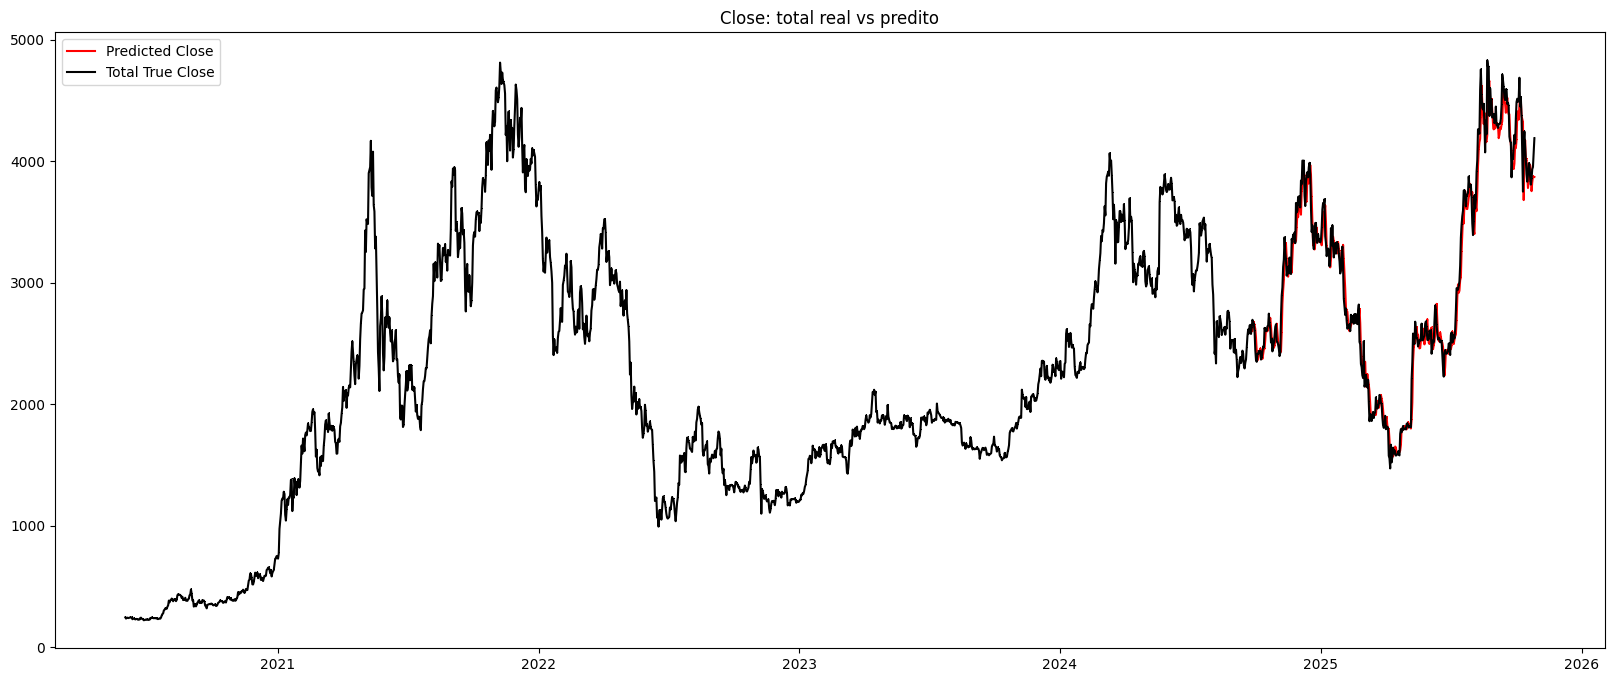

In [11]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

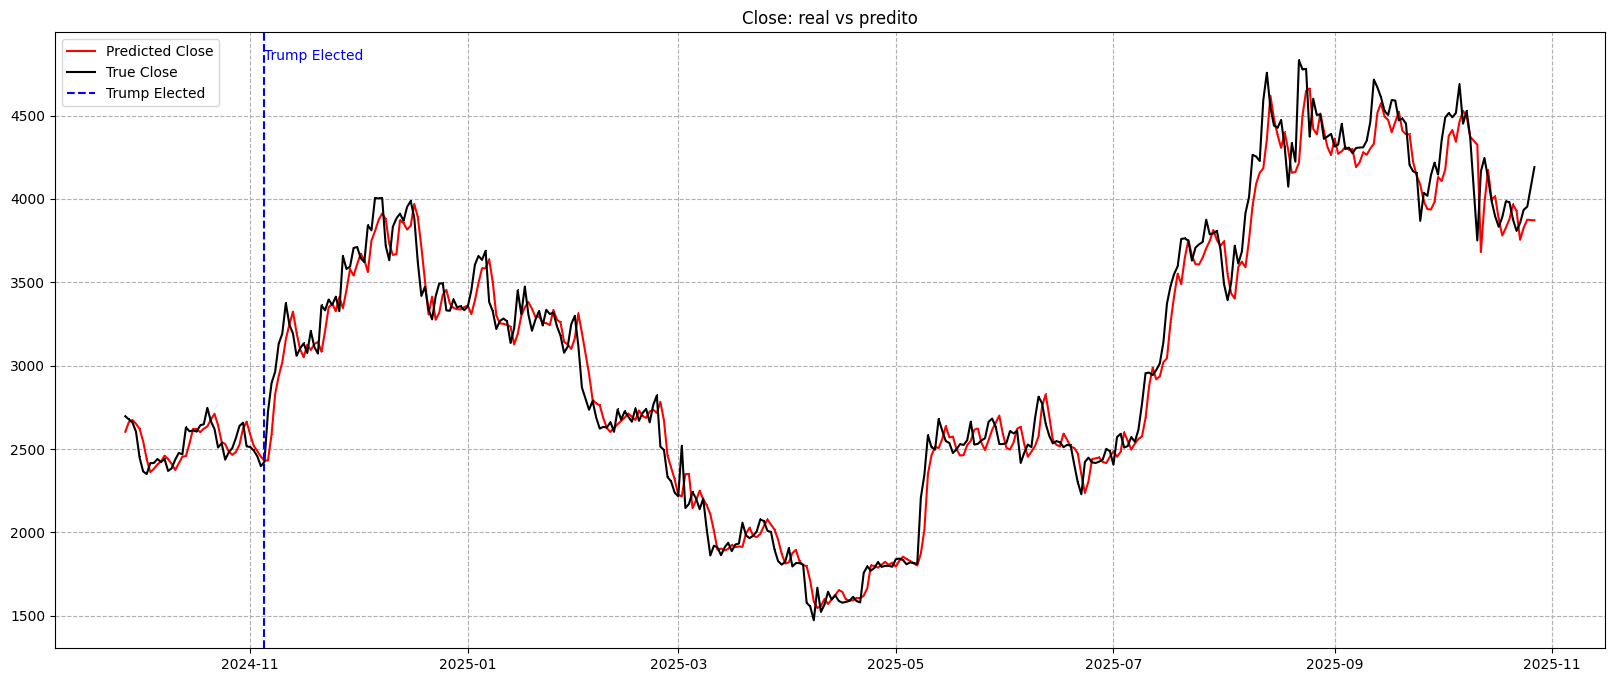

In [12]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

5 de novembro donald trump foi eleito presidente

### Modelo com dado completo com a tendencia das palavras

In [6]:
data = pd.read_csv('../../data/processed/ETH-USD_crypto_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,ethereum,crypto
Date,,,,,,,
2017-11-09,320.884003,329.451996,307.056000,308.644989,893249984,2,1
2017-11-10,299.252991,324.717987,294.541992,320.670990,885985984,2,1
2017-11-11,314.681000,319.453003,298.191986,298.585999,842300992,1,1
2017-11-12,307.907990,319.153015,298.513000,314.690002,1613479936,2,1
2017-11-13,316.716003,328.415009,307.024994,307.024994,1041889984,2,1


In [7]:
X_mult = data[['High', 'Low', 'Open', 'Volume', 'crypto']]
y_mult = data[['Close']]

In [8]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_crypto_all = MinMaxScaler(feature_range=(0, 1))
  scaler_y_crypto_all = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_crypto_all.fit(X_train_reshaped)
  X_train_scaled = scaler_X_crypto_all.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_crypto_all.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_crypto_all.fit(y_train_raw)     
  y_train_scaled = scaler_y_crypto_all.transform(y_train_raw)
  y_test_scaled = scaler_y_crypto_all.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_crypto_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_crypto_all.append({
      "model": grid_result_crypto_all.best_estimator_,
      "params": grid_result_crypto_all.best_params_,
      "rmse": -grid_result_crypto_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_crypto_all,
      "scaler_y": scaler_y_crypto_all
    })
    
    print(f"Menor RMSE: {-grid_result_crypto_all.best_score_:.3f} usando: {grid_result_crypto_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.032 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.034 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.036 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.036 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.030 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.028 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}


#### Resultados

In [9]:
for m in models_lstm_crypto_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_crypto_ordered_by_test = sorted(models_lstm_crypto_all, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_crypto_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.026691727365201534
n_splits: 10
seq_len: 30

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.026789867303134162
n_splits: 5
seq_len: 30

--- Modelo 3 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.027194512303399806
n_splits: 10
seq_len: 7

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.03453113032068278
n_splits: 5
seq_len: 14

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.03462897847862988
n_splits: 10
seq_len: 14

--- Modelo 6 ---
param

In [10]:
y_pred_scaled = lstm_crypto_ordered_by_test[0]["model"].predict(lstm_crypto_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_crypto_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_crypto_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_crypto_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_crypto_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_crypto_ordered_by_test[0]["y_test"])

MAE normalizado: 0.01894602884291992
RMSE normalizado: 0.026691727365201534


In [11]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 89.57264645894368
RMSE real: 126.19259926918156
MAPE: 2.95%
R²: 0.97


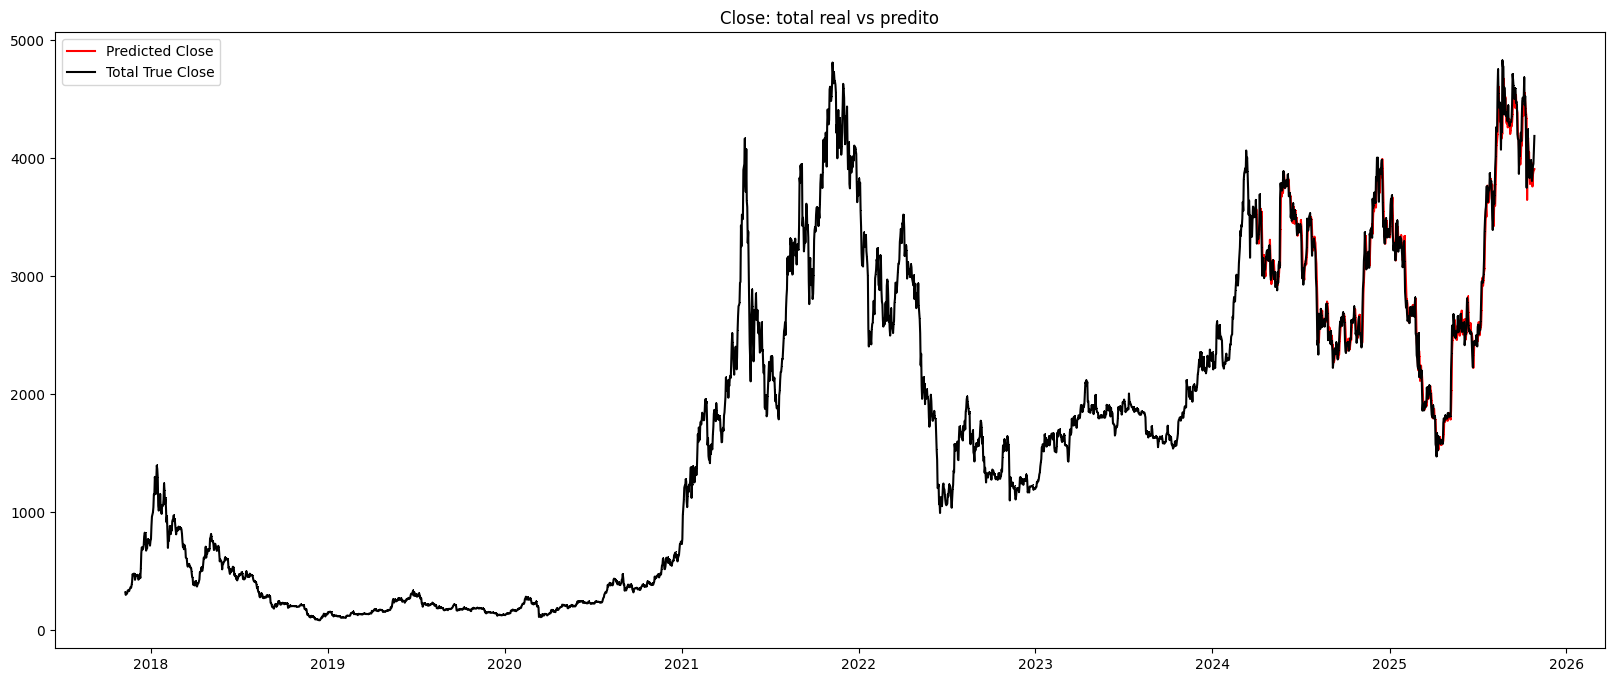

In [12]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

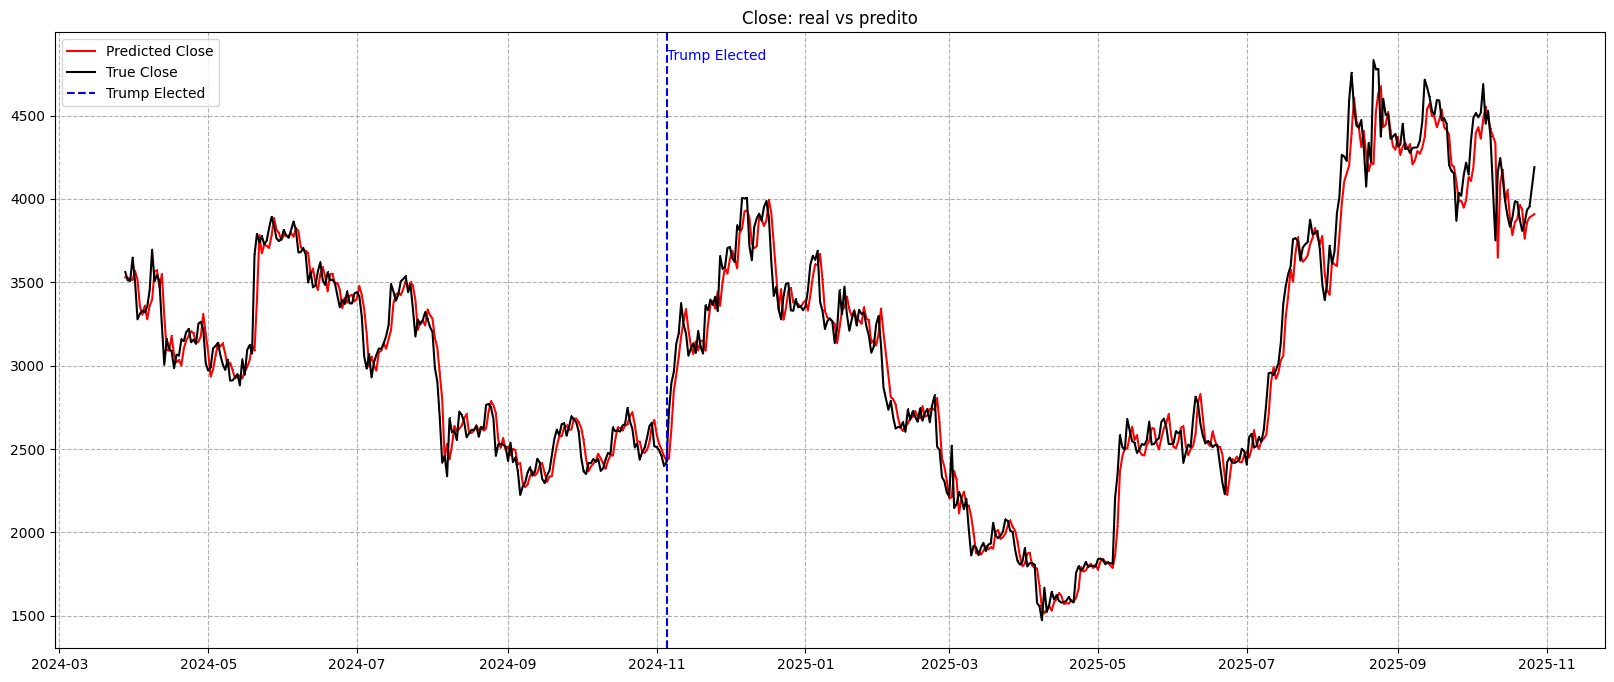

In [13]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo dado cortado com tendencia da palavra "crypto"

In [14]:
data = pd.read_csv('../../data/processed/ETH-USD_crypto_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,ethereum,crypto
Date,,,,,,,
2020-06-01,246.991760,248.236282,230.488052,230.860260,13951727936,5,6
2020-06-02,237.219055,252.222000,233.225296,246.828186,13782107567,5,6
2020-06-03,244.179321,244.179321,235.464447,237.395218,9861760817,4,5
2020-06-04,244.426392,245.928970,236.765305,244.105286,10170414304,4,6
2020-06-05,241.221985,247.329498,240.682053,244.349594,9293963914,4,5


In [15]:
X_mult = data[['High', 'Low', 'Open', 'Volume', 'crypto']]
y_mult = data[['Close']]

In [16]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences_mult(X_mult.values, y_mult.values, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_raw, X_test_raw = X_seq[:train_size], X_seq[train_size:]
  y_train_raw, y_test_raw = y_seq[:train_size], y_seq[train_size:]

  scaler_X_crypto_cropped = MinMaxScaler(feature_range=(0, 1))
  scaler_y_crypto_cropped = MinMaxScaler(feature_range=(0, 1))

  # O X é 3D (samples, timesteps, features), então precisamos achatar para escalar
  X_train_reshaped = X_train_raw.reshape(-1, X_train_raw.shape[2])
  X_test_reshaped = X_test_raw.reshape(-1, X_test_raw.shape[2])

  scaler_X_crypto_cropped.fit(X_train_reshaped)
  X_train_scaled = scaler_X_crypto_cropped.transform(X_train_reshaped).reshape(X_train_raw.shape)
  X_test_scaled = scaler_X_crypto_cropped.transform(X_test_reshaped).reshape(X_test_raw.shape)

  scaler_y_crypto_cropped.fit(y_train_raw)     
  y_train_scaled = scaler_y_crypto_cropped.transform(y_train_raw)
  y_test_scaled = scaler_y_crypto_cropped.transform(y_test_raw)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_crypto_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_crypto_cropped.append({
      "model": grid_result_crypto_cropped.best_estimator_,
      "params": grid_result_crypto_cropped.best_params_,
      "rmse": -grid_result_crypto_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Multivariado",
      "algorithm": "LSTM",
      "scaler_X": scaler_X_crypto_cropped,
      "scaler_y": scaler_y_crypto_cropped
    })
    
    print(f"Menor RMSE: {-grid_result_crypto_cropped.best_score_:.3f} usando: {grid_result_crypto_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.064 usando: {'fit__batch_size': 32, 'fit__epochs': 50, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.035 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.030 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.036 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.036 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.040 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}


#### Resultados

In [17]:
for m in models_lstm_crypto_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_crypto_cropped_ordered_by_test = sorted(models_lstm_crypto_cropped, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_crypto_cropped_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

--- Modelo 1 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.028166132499277623
n_splits: 5
seq_len: 14

--- Modelo 2 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.029001632936659933
n_splits: 5
seq_len: 30

--- Modelo 3 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
rmse_test: 0.029717222683808837
n_splits: 10
seq_len: 7

--- Modelo 4 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.3, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.030167221751544432
n_splits: 10
seq_len: 14

--- Modelo 5 ---
params: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
rmse_test: 0.030727798837549582
n_splits: 10
seq_len: 30

--- Modelo 6 ---
p

In [18]:
y_pred_scaled = lstm_crypto_cropped_ordered_by_test[0]["model"].predict(lstm_crypto_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_crypto_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_crypto_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = lstm_crypto_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(y_pred_scaled)
y_test = lstm_crypto_cropped_ordered_by_test[0]["scaler_y"].inverse_transform(lstm_crypto_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.02043411041096947
RMSE normalizado: 0.028166132499277623


In [19]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 93.77474601901308
RMSE real: 129.25798323549415
MAPE: 3.11%
R²: 0.98


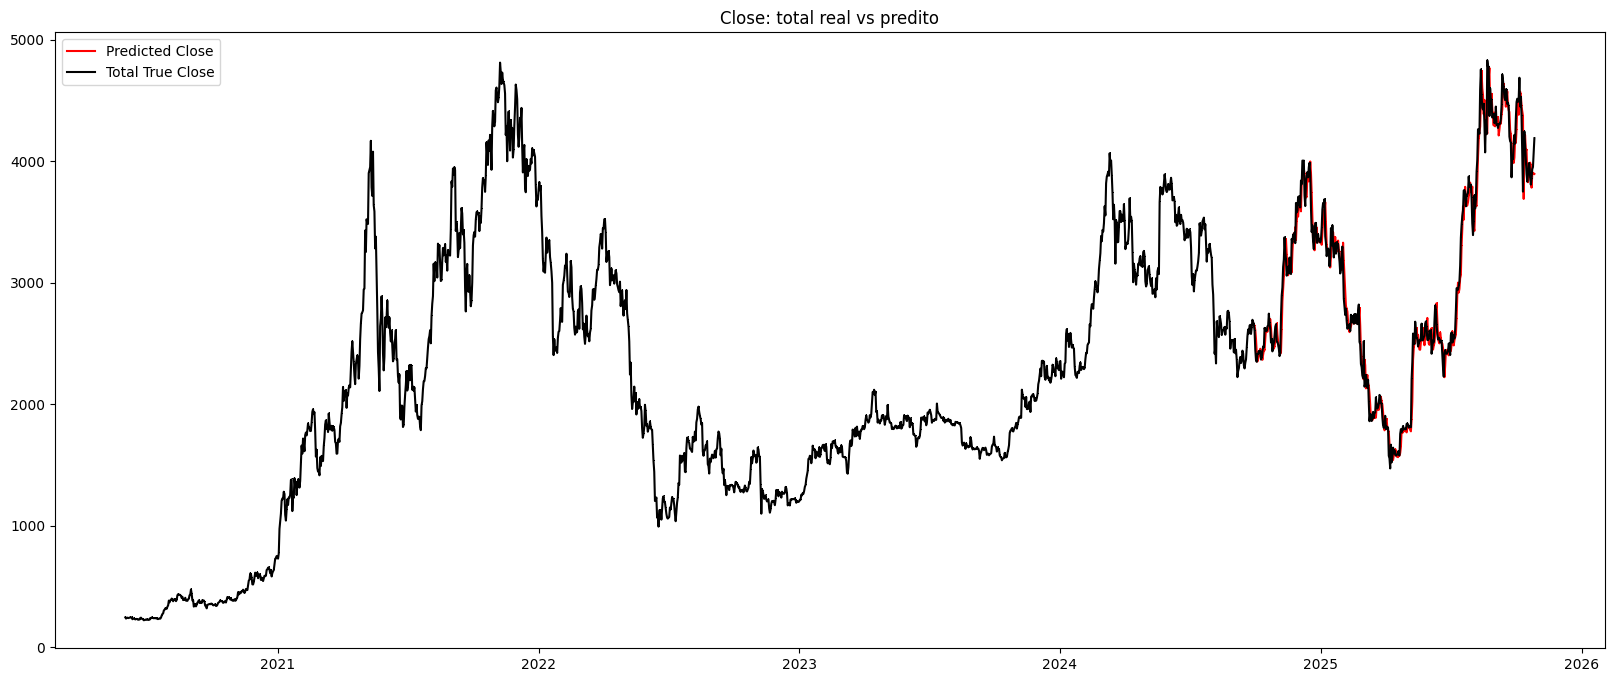

In [20]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

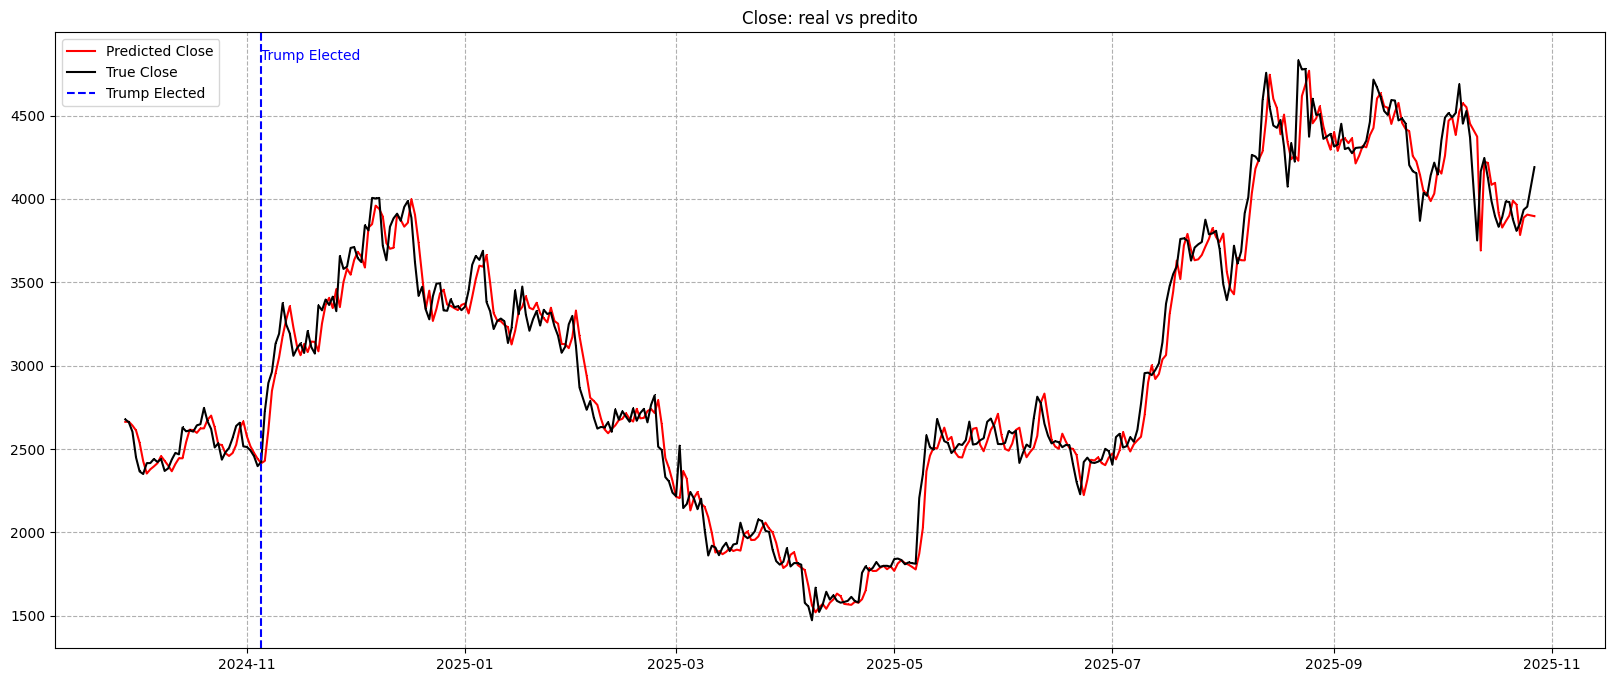

In [21]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()